# Predicting fluxes on grid

To do:
 
* Implement confidence intervals using `forestci` https://github.com/scikit-learn-contrib/forest-confidence-interval
* Mask with LC dataset so permenant water and urban areas are masked


In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
from joblib import load
from matplotlib import pyplot as plt
from datacube.utils.dask import start_local_dask

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/dea_tools')
from classification import predict_xr, HiddenPrints

In [2]:
client = start_local_dask(mem_safety_margin='2Gb')
client

/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34231 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34231/status,
Dashboard: /proxy/34231/status,Workers: 1
Total threads: 8,Total memory: 22.46 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43085,Workers: 1
Dashboard: /proxy/34231/status,Total threads: 8
Started: Just now,Total memory: 22.46 GiB
Comm: tcp://127.0.0.1:41303,Total threads: 8
Dashboard: /proxy/39447/status,Memory: 22.46 GiB
Nanny: tcp://127.0.0.1:42309,


## Analysis Parameters

In [3]:
var = 'NEE'
results_name='NEE_modelled_2003_2021.nc'
model_path = '/g/data/os22/chad_tmp/NEE_modelling/results/models/AUS_NEE_RF_model.joblib'
data_path = '/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/prediction_data_2003_2021.nc'

## Open model

In [4]:
model = load(model_path).set_params(n_jobs=1)

## Open predictor data

In [5]:
data = xr.open_dataset(data_path).set_coords('spatial_ref')

### Predict each time-step seperately

- TO DO: fix timesteps that come back from `predict_xr`

In [6]:
mask = data.to_array().isnull().any('variable')

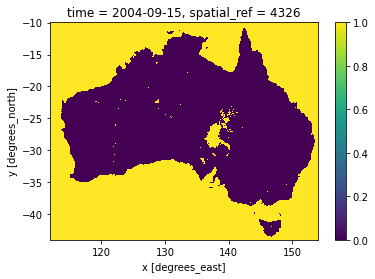

In [7]:
mask.isel(time=20).plot.imshow()

In [10]:
data = data.drop('PFT')

### Check training and prediction variable order

In [11]:
print(list(data.data_vars))
print('\n')      
print(list(pd.read_csv('/g/data/os22/chad_tmp/NEE_modelling/results/variables.txt')))

['LAI', 'EVI', 'LST', 'Fpar', 'tree_cover', 'nontree_cover', 'nonveg_cover', 'LST-Tair', 'MI', 'solar', 'Ta', 'VPD', 'precip', 'precip_cml_3', 'precip_cml_6', 'TWI']


['LAI_RS', 'EVI_RS', 'LST_RS', 'Fpar_RS', 'tree_cover_RS', 'nontree_cover_RS', 'nonveg_cover_RS', 'LST-Tair_RS', 'MI_RS', 'solar_RS', 'Ta_RS', 'VPD_RS', 'precip_RS', 'precip_cml_3_RS', 'precip_cml_6_RS', 'TWI_RS', 'Unnamed: 16']


In [12]:
results = []

i=0
#start from 3 as these time-steps doesn't have rainfall lag values
for i in range(0, len(data.time)): 
    print(" {:03}/{:03}\r".format(i + 1, len(range(0, len(data.time)))), end="")
    with HiddenPrints():
        predicted = predict_xr(model,
                            data.isel(time=i),
                            proba=False,
                            clean=True,
                              ).compute()
    
    predicted = predicted.Predictions.where(~mask.isel(time=i))
    predicted['time'] = data.isel(time=i).time.values
    results.append(predicted)
    i+=1

In [13]:
ds = xr.concat(results, dim='time').sortby('time').rename(var)

In [14]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name)